**AI & Machine Learning (KAN-CINTO4003U) - Copenhagen Business School | Spring 2025**

***


# Part I: RAG

Please see the description of the assignment in the README file (section 1) <br>
**Guide notebook**: [guides/rag_guide.ipynb](guides/rag_guide.ipynb)


***
<br>

* Remember to include some reflections on your results. Are there, for example, any hyperparameters that are particularly important?

* You should follow the steps given in the `rag_guide` notebook to create your own RAG system.

<br>

***

#### Imports

In [3]:
from decouple import config
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from instructor import Mode
from langchain_chroma import Chroma
from langchain_community.document_loaders import TextLoader
from langchain_core.documents import Document
from langchain_ibm import WatsonxEmbeddings, WatsonxLLM
from langchain_text_splitters.markdown import RecursiveCharacterTextSplitter
from langchain.prompts import PromptTemplate
from langgraph.graph import START, StateGraph
from litellm import completion
from pydantic import BaseModel, Field
from tqdm import tqdm
from typing import Literal, Any
from typing_extensions import TypedDict
import instructor
import litellm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### Retrieve secrets

In [4]:
WX_API_KEY = config("WX_API_KEY")
WX_PROJECT_ID = config("WX_PROJECT_ID")
WX_API_URL = "https://us-south.ml.cloud.ibm.com"

#### Authenticate and initialize LLM

In [5]:
llm = WatsonxLLM(

        model_id= "ibm/granite-3-8b-instruct",
        url=WX_API_URL,
        apikey=WX_API_KEY,
        project_id=WX_PROJECT_ID,

        params={
            GenParams.DECODING_METHOD: "greedy",
            GenParams.TEMPERATURE: 0,
            GenParams.MIN_NEW_TOKENS: 5,
            GenParams.MAX_NEW_TOKENS: 1_000,
            GenParams.REPETITION_PENALTY:1.2
        }

)

#### Load documents

In [6]:
# Load structured CBS knowledge base
df = pd.read_csv("data/combined/Combined.csv")

# Prepare LangChain Document objects with metadata
chunks = []

for _, row in df.iterrows():
    metadata = {
        "url": row["url"],
        "section_title": row["section_title"]
    }

    max_chars = 300

    base_text = "page_name: " + str(row.get("page_name", "") or "") + " text: " + str(row.get("text_chunk", "") or "")
    
    if len(base_text) <= max_chars:
        chunks.append(Document(page_content=base_text, metadata=metadata))
    else:
        # Split the content into chunks of max_chars
        parts = [base_text[i:i + max_chars].strip() for i in range(0, len(base_text), max_chars)]
        for idx, part in enumerate(parts, start=1):
            updated_metadata = metadata.copy()
            updated_metadata["section_title"] = f"{metadata['section_title']} (Part {idx})"
            chunks.append(Document(page_content=part, metadata=updated_metadata))

print(f"Loaded {len(chunks)} chunks.")

Loaded 63264 chunks.


In [6]:
chunks

[Document(metadata={'url': 'https://www.cbs.dk/en/study/graduate', 'page_name': 'Graduate', 'section_title': 'Start your graduate studies at CBS', 'section_type': 'other'}, page_content='At CBS, you can choose between more than 30 different graduate programmes, all with their own specialisation. Our programmes are based on a strong and internationally renowned research base and here, you will find a number of programmes combining business studies with politics, sociology, language, IT, communication, and more. Find all the graduate programmes at CBS.'),
 Document(metadata={'url': 'https://www.cbs.dk/en/study/graduate', 'page_name': 'Graduate', 'section_title': 'How to choose', 'section_type': 'other'}, page_content='When choosing which graduate programme to apply for, there are some considerations that are important to have made first. Learn more about the five questions you should ask yourself before you choose a graduate programme. A good idea is also to visit Open Days at CBS. Here,

#### Initialize the embedding model

In [7]:
embed_params = {}

watsonx_embedding = WatsonxEmbeddings(
    model_id="ibm/granite-embedding-278m-multilingual",
    url=WX_API_URL,
    project_id=WX_PROJECT_ID,
    apikey=WX_API_KEY,
    params=embed_params,
)

#### Create vector index

In [8]:
local_vector_db = Chroma.from_documents(
    collection_name="my_collection",
    embedding=watsonx_embedding,
    persist_directory="my_vector_db", # This will save the vector database to disk! Delete it if you want to start fresh.
    documents=chunks,
)

#### Create a RAG prompt template

In [9]:
template = """You are a helpful assistant answering questions about CBS graduate programmes. Use the provided context to generate a clear and accurate response. If the answer is not in the context, say you don't know. Keep the answer concise—no more than three sentences.

Question:
{question}

Context: 
{context} 

Answer:
"""

prompt = PromptTemplate.from_template(template)

#### Creating RAG pipeline

In [ ]:
# Define state for application
class State(TypedDict):
    """ A langgraph state for the application """
    question: str
    context: list[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    """ Our retrieval step. We use our local vector database to retrieve similar documents to the question """
    retrieved_docs = local_vector_db.similarity_search(state["question"], k=11) # NOTE: You can change k to retrieve fewer or more documents
    return {"context": retrieved_docs} 


def generate(state: State):
    """ Our generation step. We use the retrieved documents to generate an answer to the question """

    # Format the prompt
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    formated_prompt = prompt.invoke({"question": state["question"], "context": docs_content})

    # Generate the answer
    response = llm.invoke(formated_prompt)
    return {"answer": response}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve") # Start at the retrieve step
graph = graph_builder.compile() # Compile the graph

In [17]:
response = graph.invoke({"question": "When is the application deadline for MSc in Business Administration and Information Systems?"})

response

{'question': 'When is the application deadline for MSc in Business Administration and Information Systems?',
 'context': [Document(id='3ceb8aae-c6aa-4d0d-ad1e-f5894974c6d5', metadata={'section_title': 'IT - Master of Science (MSc) in Business Administration and Information Systems (Part 11)', 'url': 'https://studieordninger.cbs.dk/2024/kan/1163'}, page_content='page_name: IT - Master of Science (MSc) in Business Administration and Information Systems text: The deadline for completing the programme is rated time of study + one year after the student commenced the programme. Leave periods, if any, are not included in this time frame.'),
  Document(id='d7097d76-9015-4dd4-bfbb-d9bf07a06ed7', metadata={'section_title': 'IT - Master of Science (MSc) in Business Administration and Information Systems (Part 54)', 'url': 'https://studieordninger.cbs.dk/2024/kan/1163'}, page_content='page_name: IT - Master of Science (MSc) in Business Administration and Information Systems text: See also section

#### Create Question-Answer pairs (Gold standard examples)

In [12]:
sample_queries = [
    "What graduate programmes are offered at CBS?",
    "How should I choose the right master's programme at CBS?",
    "What are the general admission requirements for graduate programmes?",
    "How can I improve my chances of being admitted to a CBS graduate programme?",
    "Is it possible to apply if I don't meet all entry requirements?",
    "What level of English proficiency is required for admission?",
    "Are there any legal rights regarding CBS admission decisions?",
    "What does CBS recommend for preparing a strong application?",
    "Can I qualify for multiple graduate programmes with the same bachelor's degree?",
    "What support does CBS offer to international graduate students?",
    "What are CBS’s application deadlines for graduate admission?",
    "Does CBS offer graduate programmes in English?",
    "What is the structure of the MSc in Finance and Strategic Management programme?",
    "How competitive is admission to CBS graduate programmes?",
    "Do I need work experience to apply for CBS graduate programmes?",
    "How are GPA requirements handled at CBS?",
    "Can I apply for conditional admission if I haven't completed my bachelor’s degree?",
    "What documents must be submitted with the CBS graduate application?",
    "Are motivational statements required for CBS programmes?",
    "How long do CBS graduate programmes typically take to complete?",
    "What specialisations are available within MSc in Economics and Business Administration?",
    "Can I study part-time for a graduate programme at CBS?",
    "Is it possible to transfer credits from another university to CBS graduate programmes?",
    "What happens if I miss the CBS application deadline?",
    "Is there an early admission process at CBS?",
    "What are the tuition fees for CBS graduate programmes?",
    "Does CBS offer scholarships for graduate students?",
    "What are the housing options for CBS graduate students?",
    "Is there an age limit for applying to CBS graduate programmes?",
    "How important is relevant academic background for admission?",
    "Can professional experience compensate for lacking academic prerequisites?",
    "What is the role of interviews in CBS graduate admissions?",
    "Can international students apply to all CBS graduate programmes?",
    "Are recommendation letters required for CBS applications?",
    "How are waiting lists managed for CBS graduate admissions?",
    "What happens after submitting an application to CBS?",
    "What master's degrees does CBS offer in innovation or entrepreneurship?",
    "What are CBS's graduate programmes related to international business?",
    "What is the teaching style like in CBS graduate programmes?",
    "How much group work is involved in CBS master's programmes?",
    "What career services does CBS offer to graduate students?",
    "Are internships part of CBS graduate programmes?",
    "Can CBS graduates stay in Denmark after graduation to work?",
    "Does CBS accept late applications for graduate admission?",
    "Can I get feedback if my CBS graduate application is rejected?",
    "How do I prove my English Level A proficiency for CBS?",
    "Is a GMAT or GRE score required for CBS graduate admission?",
    "What is CBS's policy on reapplying if initially rejected?",
    "Does CBS offer double degree programmes at the graduate level?",
    "Are there exchange opportunities for CBS graduate students?",
    "Which master's programmes at CBS focus on innovation?",
    "What does the MSc in Business Administration and Digital Business cover?",
    "Is the MSc in Finance and Strategic Management offered in English?",
    "What are the entry requirements for MSc in International Business?",
    "Can I apply to the MSc in Data Science without a technical bachelor's?",
    "How many ECTS are required for CBS master's admissions?",
    "Does CBS offer part-time master's programmes?",
    "What is the structure of MSc in Information Systems at CBS?",
    "Are there English-taught master's programmes for marketing at CBS?",
    "What is the difference between Cand.merc. and Cand.soc. programmes?",
    "Can you explain CBS’s MSc in Innovation in Health Care?",
    "Are there any CBS master's programmes with a focus on communication?",
    "What’s unique about the Strategic Design and Entrepreneurship master's?",
    "Do any CBS master’s programmes include internships?",
    "Is there a master's programme combining psychology and business at CBS?",
    "What is the focus of MSc in Bioentrepreneurship at CBS?",
    "Can international students apply to the MSc in Organizational Innovation?",
    "What kind of jobs do CBS master's graduates typically pursue?",
    "Does the MSc in Philosophy combine business and humanities?",
    "Can I take electives in CBS master’s programmes?",
    "What is the course Digital Marketing & Social Media about?",
    "Which programme includes the course Digital Marketing & Social Media?",
    "What are the learning objectives of the Digital Marketing & Social Media course?",
    "What teaching methods are used in Digital Marketing & Social Media?",
    "How is the Digital Marketing & Social Media course assessed?",
    "What is the course Corporate Finance about?",
    "Which programme includes the course Corporate Finance?",
    "What are the learning objectives of the Corporate Finance course?",
    "What teaching methods are used in Corporate Finance?",
    "How is the Corporate Finance course assessed?",
    "What is the course Organizational Behaviour about?",
    "Which programme includes the course Organizational Behaviour?",
    "What are the learning objectives of the Organizational Behaviour course?",
    "What teaching methods are used in Organizational Behaviour?",
    "How is the Organizational Behaviour course assessed?",
    "What is the course Strategic Management about?",
    "Which programme includes the course Strategic Management?",
    "What are the learning objectives of the Strategic Management course?",
    "What teaching methods are used in Strategic Management?",
    "How is the Strategic Management course assessed?",
    "What is the course Entrepreneurship and Innovation in Context about?",
    "Which programme includes the course Entrepreneurship and Innovation in Context?",
    "What are the learning objectives of the Entrepreneurship and Innovation in Context course?",
    "What teaching methods are used in Entrepreneurship and Innovation in Context?",
    "How is the Entrepreneurship and Innovation in Context course assessed?",
    "What is the course Bioentrepreneurship about?",
    "What is the course Strategic Management of Innovation and Technology about?",
    "What is the course Organizational Behavior: Arts and Culture about?",
    "What is the course Financing Innovation and Entrepreneurship about?",
    "What is the course Entrepreneurship and Innovation - a Business Game about?"

]

expected_responses = [
    "CBS offers more than 30 diverse graduate programmes across finance, business, economics, and management.",
    "CBS advises students to align their academic background and career goals with programme entry requirements.",
    "General admission requires a relevant bachelor’s degree and English proficiency at Level A.",
    "Applicants can improve admission chances by meeting all academic requirements and submitting strong supporting documents.",
    "Applicants who do not fully meet entry requirements may still be evaluated on a case-by-case basis.",
    "CBS requires proof of English Level A, typically through TOEFL, IELTS, or similar certifications.",
    "CBS states that meeting minimum requirements does not guarantee admission, and no legal claim can be made.",
    "CBS recommends early preparation, checking specific programme requirements, and timely document submission.",
    "Depending on content overlap, one bachelor’s degree may qualify for multiple programmes, but requirements vary.",
    "CBS provides extensive international student support services including housing, visas, and orientation.",
    "Application deadlines are typically in January for non-EU students and March for EU/EEA students.",
    "Yes, CBS offers many graduate programmes fully taught in English.",
    "The MSc in Finance and Strategic Management combines corporate finance, financial strategy, and international perspectives.",
    "CBS graduate admission is highly competitive; strong academic performance is critical.",
    "Work experience is not required but can strengthen applications to some programmes.",
    "GPA requirements vary by programme but a strong academic record is generally expected.",
    "Students in their final bachelor’s semester can apply for conditional admission.",
    "Required documents include transcripts, diplomas, proof of English proficiency, and specific programme supplements.",
    "Some programmes require a motivational statement as part of the application package.",
    "Most CBS graduate programmes take two years (four semesters) to complete.",
    "Specialisations under MSc Economics and Business Administration include finance, marketing, and innovation management.",
    "Most CBS graduate programmes are full-time; part-time options are rare.",
    "Credit transfers are possible but rare and handled individually by programme offices.",
    "Missing the deadline usually results in the application being rejected for that intake.",
    "CBS does not currently offer an early admission process for graduate programmes.",
    "There are no tuition fees for EU/EEA students; fees apply for non-EU/EEA students.",
    "CBS offers scholarships mainly to non-EU/EEA students based on academic merit.",
    "CBS graduate students have access to housing options via CBS Housing Department.",
    "There is no maximum age for applying to CBS graduate programmes.",
    "A directly relevant academic background significantly improves admission chances.",
    "Professional experience cannot fully substitute missing academic prerequisites but can strengthen an application.",
    "Some CBS programmes conduct interviews during the admission process.",
    "International students can apply to all CBS graduate programmes taught in English.",
    "Recommendation letters are not required for most CBS graduate programmes.",
    "Waiting lists are managed based on programme-specific procedures and ranking lists.",
    "After submitting an application, CBS evaluates documents and communicates via the Application Portal.",
    "CBS offers master's programmes focused on innovation such as MSc in Innovation Management and Business Development.",
    "CBS offers international business-focused programmes such as MSc in International Business and Politics.",
    "CBS uses interactive lectures, real-world case studies, and group assignments as teaching methods.",
    "Group work is heavily emphasized in CBS master's programmes to simulate real business environments.",
    "CBS provides career counselling, job fairs, and internship support to graduate students.",
    "Internships are optional but encouraged in most CBS graduate programmes.",
    "Graduates can apply for a job-seeking residence permit to stay in Denmark after completing studies.",
    "CBS rarely accepts late applications; it depends on programme capacity.",
    "CBS generally does not offer individual feedback after rejection decisions.",
    "Accepted English proofs include TOEFL, IELTS, CPE, and CAE certificates.",
    "GMAT or GRE scores are not required for most CBS graduate programmes.",
    "Applicants may reapply in subsequent years if initially rejected.",
    "CBS offers double degree options in collaboration with international partner universities.",
    "Exchange semesters are available for CBS graduate students at numerous partner universities worldwide.",
    "CBS offers master's programmes in innovation such as MSc in Innovation Management and Business Development and MSc in Innovation in Health Care.",
    "The MSc in Business Administration and Digital Business focuses on IT's strategic role in digital platforms, user needs, and commercialization.",
    "Yes, the MSc in Finance and Strategic Management is fully taught in English and emphasizes corporate finance and international strategy.",
    "Entry to the MSc in International Business requires a strong foundation in business and economics, plus proof of English Level A.",
    "Technical background is preferred for MSc in Data Science, but relevant quantitative coursework may qualify a candidate.",
    "CBS typically requires a total of 180 ECTS for admission to graduate programmes, including subject-specific requirements.",
    "Most CBS master's programmes are full-time. Part-time options like the Erhvervskandidat exist but are limited.",
    "The MSc in Information Systems trains students to use IT to create value and align business and technical strategies.",
    "Yes, CBS offers English-taught programmes in marketing such as MSc in Marketing and MSc in Business Administration and Marketing.",
    "Cand.merc. focuses on business administration while Cand.soc. integrates social science disciplines like sociology and policy.",
    "CBS’s MSc in Innovation in Health Care targets students aiming to work with business and innovation in healthcare systems.",
    "Yes, the MSc in Business Administration and Corporate Communication focuses on strategic communication in organizations.",
    "Strategic Design and Entrepreneurship combines design thinking from arts with management tools for commercialization.",
    "Some CBS master's programmes include internships or project-based courses with companies, such as MSc in Bioentrepreneurship.",
    "Yes, Cand.merc.(psyk.) is a programme combining psychology and business administration to develop change agents in organizations.",
    "MSc in Bioentrepreneurship teaches students how to turn biological research into viable business ventures.",
    "Yes, international students are welcome to apply to the MSc in Organizational Innovation and Entrepreneurship programme.",
    "CBS master's graduates typically work in consulting, finance, digital strategy, innovation management, and public policy roles.",
    "MSc in Business Administration and Philosophy integrates philosophical thinking into strategy, leadership, and ethics.",
    "Most CBS programmes offer electives during the second year, allowing students to tailor their studies to specific interests.",
    "It equips students with up-to-date knowledge of digital marketing concepts and advertising agency procedures, using a flexible learning schedule that includes online lectures, readings, film lectures, case questions, and online discussions.",
    "This course is part of the MSc in International Business and Politics programme.",
    "Students learn to understand digital marketing strategies, analyze social media trends, and apply advertising concepts in real-world scenarios.",
    "The course employs online lectures, film lectures, readings, case questions, and online discussions to facilitate learning.",
    "Assessment details are provided during the course, typically involving assignments and participation in discussions.",
    "It provides a broad overview of corporate finance, covering tools that financial managers use to analyze investment and financing decisions.",
    "This course is part of the BSc in Business Administration and Project Management programme.",
    "Students learn to identify, explain, discuss, and apply core concepts, models, and methods in corporate finance.",
    "The course includes lectures and exercise classes to introduce methodological and practical concepts in modern corporate finance.",
    "Assessment details are provided during the course, typically involving written exams and assignments.",
    "It teaches students how organizations work based on organization and management scholarship.",
    "This course is part of the BSc in International Business and Politics programme.",
    "Students learn to understand organizational behavior concepts and apply them to various organizational settings.",
    "The course uses a range of teaching methods and course materials to introduce important approaches, concepts, and frameworks.",
    "Assessment is based on a home assignment - written product, with a maximum of 10 pages, to be completed individually within 72 hours.",
    "It introduces students to the key principles of strategic management, focusing on strategic analysis and contemporary topics in strategy.",
    "This course is part of the MSc in Business Administration and Commercial Law programme.",
    "Students learn to master main strategic models at both theoretical and applied levels and apply strategy to real-life cases.",
    "The course includes lectures, case studies, and discussions to engage students in the classroom.",
    "Assessment details are provided during the course, typically involving oral exams based on mini-projects and syllabus questions.",
    "It explores entrepreneurship and innovation and the conditions which economic, societal, and cultural context sets for entrepreneurial decision-making.",
    "This course is part of the MSc in Social Sciences in Organisational Innovation and Entrepreneurship programme.",
    "Students learn to understand the impact of context on entrepreneurial decisions and analyze different industries and transitions.",
    "The course uses case studies, discussions, and analysis of entrepreneurs acting in different industries.",
    "Assessment details are provided during the course, typically involving written assignments and participation.",
    "It teaches central skills in science-based entrepreneurship in the biotech sector, bridging science and business.",
    "It focuses on applying theoretical knowledge to specific problem situations, business challenges, and cases, emphasizing AI and digital platforms.",
    "It highlights particularities of organizational behavior in the specific case of arts and culture through global examples.",
    "It helps students analyze entrepreneurial and innovative projects associated with high ambiguity and discusses inequalities in financing.",
    "It uses a business game platform to apply theories of entrepreneurship and innovation in a practical setting, teaching students to generate and implement new solutions."

]

#### Create a vanilla RAG evaluation system

In [13]:

# create a litellm client
litellm.drop_params = True  # watsonx.ai doesn't support `json_mode`
client = instructor.from_litellm(completion, mode=Mode.JSON)

# create a response model - LLM is forced to return an object of this type
class JudgeResponse(BaseModel):
    reasoning: str = Field(description="Short one-sentence reason for score")
    score: Literal[0, .5, 1] = Field(description="Final score")

# define a function to call the judge
def call_judge(prompt : str) -> JudgeResponse:
    response = client.chat.completions.create(
        model="watsonx/meta-llama/llama-3-3-70b-instruct",
        max_tokens=1024,
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        project_id=WX_PROJECT_ID,
        apikey=WX_API_KEY,
        api_base=WX_API_URL,
        response_model=JudgeResponse,
        # decoding_method="greedy",
        # temperature=0,
    )
    return response

In [14]:
class RAGEvaluator:
    """
    A streamlined evaluator for RAG systems focusing on three key dimensions:
    1. Retrieval Quality
    2. Answer Correctness
    3. Hallucination Detection
    """
    def __init__(self, llm_func):
        """Initialize with an LLM."""
        self.llm_func = llm_func
            
    def evaluate_retrieval_quality(self, response: dict[str, Any], expected_answer: str, verbose : bool = False) -> JudgeResponse:
        """
        Ask LLM if retrieved documents contain information needed for the expected answer.
        """
        # Combine all retrieved document contents with clear formatting
        retrieved_text = "\n\n".join([f"Document {i+1}:\n{doc.page_content}" for i, doc in enumerate(response.get('context', []))])
        
        prompt = f"""You are given a set of documents about master programs at CBS and a fact. Can the fact be found in the documents? Judge by the information, not the exact wording of the fact.
        
        - Respond with 1 if the fact is present (also if the fact can be pieced together from multiple documents).
        - Respond with 0 if the fact is not present in any of the documents.
        - Responds with 0.5 ff only part of the fact is present.
        
        Retrieved Documents: 
        {retrieved_text}

        Fact:
        {expected_answer}
        
        Can the fact be found in the documents? Respond as a JudgeResponse object with: 
        - a short reason (max 20 words)
        - a score of 1, 0.5, or 0.
        """
        
        result = self.llm_func(prompt)
        if verbose:
            print(f"[evaluation_retrieval_quality] LLM response: {result}")
        return result
    
    def evaluate_answer_correctness(self, response: dict[str, Any], expected_answer: str, verbose : bool = False) -> JudgeResponse:
        """
        Ask LLM to rate how correct/similar the generated answer is to the expected answer.
        """
        generated_answer = response.get('answer', '')
        
        prompt = f"""You are evaluating a RAG system with academic knowledge base about CBS Master programs. You are given a question, an expected answer, and a generated answer. Is the generated answer as correct - or close to as correct - as the expected answer? 
        
        - Respond with 1 if the answer is yes (also if the answer is more detailed than expected)
        - Respond with 0 if the answer is no. 
        - respond with 0.5 if the generated answer is partially correct

        Question:
        {response.get('question', '')}
        
        Expected answer:
        {expected_answer}
        
        Generated answer:
        {generated_answer}
        
        Is the generated answer correct enough? Consider content correctness rather than exact wording. 
        Respond as a JudgeResponse object with: 
        - a short reason (max 20 words)
        - a score of 1, 0.5, or 0."""
        
        result = self.llm_func(prompt)
        if verbose:
            print(f"[evaluation_answer_correctness] LLM response: {result}")
        return result
    
    def evaluate_hallucination(self, response: dict[str, Any], verbose : bool = False) -> JudgeResponse:
        """
        Ask LLM to evaluate if the answer contains hallucinations.
        """
        generated_answer = response.get('answer', '')
        retrieved_text = "\n\n".join([f"Document {i+1}:\n{doc.page_content}" for i, doc in enumerate(response.get('context', []))])
        
        prompt = f"""You are evaluating a RAG system with academic knowledge base about CBS Master programs. Your task is to determine if the generated answer contains hallucinations. Hallucinations are any information that is not directly supported by the retrieved documents. Does the generated answer contain hallucinations? 
        
        - If the answer is no, respond with 0. 
        - If the answer is yes, respond with 1.
        - If the answer is partially hallucinated, respond with 0.5. 
        - If the generated answer states that it does not know, respond with 0.

        Question: 
        {response.get('question', '')}
        
        Retrieved context (this is all the information the AI had access to):
        {retrieved_text}
        
        Generated answer:
        {generated_answer}
        
        Does the generated answer contain hallucinations? Respond as a JudgeResponse object with: 
        - a short reason (max 20 words)
        - a score of 1, 0.5, or 0.
        """
        
        result = self.llm_func(prompt)
        if verbose:
            print(f"[evaluation_hallucination] LLM response: {result}")
        return result
    
    def evaluate(self, response: dict[str, Any], expected_answer: str, verbose : bool = False) -> dict[str, Any]:
        """
        Evaluate a RAG response across all three dimensions.
        """
        # Get scores for each dimension
        retrieval_score = self.evaluate_retrieval_quality(response, expected_answer, verbose=verbose)
        correctness_score = self.evaluate_answer_correctness(response, expected_answer, verbose=verbose)
        hallucination_score = self.evaluate_hallucination(response, verbose=verbose)
        
        return {
            "query": response.get("question", ""),
            "retrieved_context": response.get("context", []),
            "generated_answer": response.get("answer", ""),
            "expected_answer": expected_answer,
            "retrieval_quality": retrieval_score.score,
            "answer_correctness": correctness_score.score, 
            "hallucination_score": hallucination_score.score,  # Lower is better

            # keep the reasoning for manual inspection
            "retrieval_quality_reasoning": retrieval_score.reasoning,
            "answer_correctness_reasoning": correctness_score.reasoning,
            "hallucination_reasoning": hallucination_score.reasoning
        }


def evaluate_rag_system(graph, test_queries, expected_responses, evaluator, verbose=False):
    """
    Evaluate a RAG system containing information about CBS master programs on a test set.
    
    Args:
        graph: The LangGraph RAG system with invoke method
        test_queries: List of questions to test
        expected_responses: List of expected answers
        evaluator: The RAG evaluator object
        
    Returns:
        Evaluation results
    """
    results = []
    
    for query, expected in tqdm(zip(test_queries, expected_responses), total=len(test_queries)):

        # Get RAG response
        response = graph.invoke({"question": query})
        
        # Evaluate
        eval_result = evaluator.evaluate(response, expected, verbose=verbose)
        results.append(eval_result)
    
    # Calculate average scores
    avg_metrics = {
        "retrieval_quality": np.mean([r["retrieval_quality"] for r in results]),
        "answer_correctness": np.mean([r["answer_correctness"] for r in results]),
        "hallucination": np.mean([r["hallucination_score"] for r in results])
    }

    return {
        "individual_results": results,
        "scores": avg_metrics,
        "num_queries": len(test_queries)
    }

In [22]:
results = evaluate_rag_system(
    graph, 
    sample_queries,
    expected_responses,
    evaluator=RAGEvaluator(llm_func=call_judge),
    verbose=True
)

results["scores"]

  0%|          | 0/100 [00:00<?, ?it/s]

[evaluation_retrieval_quality] LLM response: reasoning='Diverse programmes mentioned' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='Partially correct info' score=0.5


  1%|          | 1/100 [00:07<12:34,  7.62s/it]

[evaluation_hallucination] LLM response: reasoning='Mentions specific disciplines not in context' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Implicit in admission requirements' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


  2%|▏         | 2/100 [00:14<11:42,  7.17s/it]

[evaluation_hallucination] LLM response: reasoning='No unsupported info' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Insufficient info' score=0
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


  3%|▎         | 3/100 [00:20<11:03,  6.84s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is supported by documents' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Implicit in multiple docs' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


  4%|▍         | 4/100 [00:27<10:49,  6.77s/it]

[evaluation_hallucination] LLM response: reasoning='Contains unsupported information' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Partial info present' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


  5%|▌         | 5/100 [00:34<10:35,  6.69s/it]

[evaluation_hallucination] LLM response: reasoning='Mentions additional coursework' score=1
[evaluation_retrieval_quality] LLM response: reasoning='English Level A mentioned' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


  6%|▌         | 6/100 [00:41<10:44,  6.85s/it]

[evaluation_hallucination] LLM response: reasoning='Mentions TOEFL iBT' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Minimum requirements mentioned' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='Partially correct' score=0.5


  7%|▋         | 7/100 [00:47<10:25,  6.72s/it]

[evaluation_hallucination] LLM response: reasoning='Non-reviewable by courts is not supported' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Implicit in multiple docs' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='Partially correct advice' score=0.5


  8%|▊         | 8/100 [00:54<10:10,  6.64s/it]

[evaluation_hallucination] LLM response: reasoning='Answer partially supported' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Requirements vary' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


  9%|▉         | 9/100 [01:00<09:52,  6.52s/it]

[evaluation_hallucination] LLM response: reasoning='Answer supported by context' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Partial support services' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='Partially correct support' score=0.5


 10%|█         | 10/100 [01:07<10:07,  6.75s/it]

[evaluation_hallucination] LLM response: reasoning='Partial info not supported' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Deadlines not specified' score=0
[evaluation_answer_correctness] LLM response: reasoning='Lacks specific deadlines' score=0


 11%|█         | 11/100 [01:15<10:17,  6.94s/it]

[evaluation_hallucination] LLM response: reasoning='No unsupported info' score=0
[evaluation_retrieval_quality] LLM response: reasoning='English requirement mentioned' score=1
[evaluation_answer_correctness] LLM response: reasoning='Similar content' score=1


 12%|█▏        | 12/100 [01:20<09:41,  6.60s/it]

[evaluation_hallucination] LLM response: reasoning='Supported by Document 7' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact partially inferred' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='Different aspects covered' score=0.5


 13%|█▎        | 13/100 [01:27<09:22,  6.46s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is supported by documents' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Competitiveness implied' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 14%|█▍        | 14/100 [01:33<09:04,  6.33s/it]

[evaluation_hallucination] LLM response: reasoning='Supported by retrieved context' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Work experience not mentioned' score=0
[evaluation_answer_correctness] LLM response: reasoning='More detailed, still correct' score=1


 15%|█▌        | 15/100 [01:39<09:07,  6.44s/it]

[evaluation_hallucination] LLM response: reasoning='No direct info on work experience' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='No GPA info' score=0
[evaluation_answer_correctness] LLM response: reasoning='Partially correct info' score=0.5


 16%|█▌        | 16/100 [01:46<09:03,  6.47s/it]

[evaluation_hallucination] LLM response: reasoning='No direct GPA info' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Implicit in CBS rules' score=1
[evaluation_answer_correctness] LLM response: reasoning='Incorrect admission requirement' score=0


 17%|█▋        | 17/100 [01:52<08:54,  6.44s/it]

[evaluation_hallucination] LLM response: reasoning='Answer not supported by context' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Partial info found' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 18%|█▊        | 18/100 [01:59<09:04,  6.64s/it]

[evaluation_hallucination] LLM response: reasoning='CV and letters not mentioned' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Mentioned in Document 1' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is overly broad' score=0.5


 19%|█▉        | 19/100 [02:06<08:51,  6.57s/it]

[evaluation_hallucination] LLM response: reasoning='Directly supported by Document 1' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Four semesters mentioned' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


 20%|██        | 20/100 [02:12<08:42,  6.53s/it]

[evaluation_hallucination] LLM response: reasoning='Mentions trimesters, not supported' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Finance mentioned' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='More detailed' score=1


 21%|██        | 21/100 [02:18<08:31,  6.48s/it]

[evaluation_hallucination] LLM response: reasoning='Supported by retrieved documents' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Part-time options mentioned' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='Incorrect part-time info' score=0


 22%|██▏       | 22/100 [02:25<08:22,  6.44s/it]

[evaluation_hallucination] LLM response: reasoning='Answer partially unsupported' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Credit transfer mentioned' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 23%|██▎       | 23/100 [02:31<08:16,  6.45s/it]

[evaluation_hallucination] LLM response: reasoning='Supported by documents' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Deadline info present' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='Partially correct information' score=0.5


 24%|██▍       | 24/100 [02:37<07:55,  6.26s/it]

[evaluation_hallucination] LLM response: reasoning='No direct info' score=0
[evaluation_retrieval_quality] LLM response: reasoning='No early admission mentioned' score=0
[evaluation_answer_correctness] LLM response: reasoning='Similar content' score=1


 25%|██▌       | 25/100 [02:44<07:56,  6.35s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Tuition fees apply for non-EU/EEA' score=1
[evaluation_answer_correctness] LLM response: reasoning='Lacks specific info' score=0


 26%|██▌       | 26/100 [02:51<08:04,  6.55s/it]

[evaluation_hallucination] LLM response: reasoning='No unsupported info' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Scholarships for non-EU/EEA' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed, same content' score=1


 27%|██▋       | 27/100 [02:57<07:57,  6.54s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is supported by documents' score=0
[evaluation_retrieval_quality] LLM response: reasoning='No housing info' score=0
[evaluation_answer_correctness] LLM response: reasoning='Lacks specific info' score=0


 28%|██▊       | 28/100 [03:04<07:48,  6.51s/it]

[evaluation_hallucination] LLM response: reasoning='No direct info' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Age not mentioned' score=0
[evaluation_answer_correctness] LLM response: reasoning='Partially correct information' score=0.5


 29%|██▉       | 29/100 [03:10<07:38,  6.46s/it]

[evaluation_hallucination] LLM response: reasoning='Mentions age restrictions not in context' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Relevant background mentioned' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 30%|███       | 30/100 [03:16<07:21,  6.31s/it]

[evaluation_hallucination] LLM response: reasoning='Supported by Document 7' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact not mentioned' score=0
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


 31%|███       | 31/100 [03:22<07:11,  6.26s/it]

[evaluation_hallucination] LLM response: reasoning='Answer supported by context' score=0
[evaluation_retrieval_quality] LLM response: reasoning='No mention of interviews' score=0
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 32%|███▏      | 32/100 [03:29<07:09,  6.32s/it]

[evaluation_hallucination] LLM response: reasoning='Implied information not supported' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Implicitly mentioned' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='More detailed' score=1


 33%|███▎      | 33/100 [03:34<06:49,  6.11s/it]

[evaluation_hallucination] LLM response: reasoning='Answer adds tuition fees detail' score=1
[evaluation_retrieval_quality] LLM response: reasoning='No mention of recommendation letters' score=0
[evaluation_answer_correctness] LLM response: reasoning='Incorrect information' score=0


 34%|███▍      | 34/100 [03:40<06:42,  6.09s/it]

[evaluation_hallucination] LLM response: reasoning='Information not found' score=1
[evaluation_retrieval_quality] LLM response: reasoning='No mention of waiting lists' score=0
[evaluation_answer_correctness] LLM response: reasoning='Partially correct information' score=0.5


 35%|███▌      | 35/100 [03:47<06:40,  6.17s/it]

[evaluation_hallucination] LLM response: reasoning='Answer includes general information' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact partially described' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 36%|███▌      | 36/100 [03:53<06:46,  6.35s/it]

[evaluation_hallucination] LLM response: reasoning='Mid-March notification not found' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Similar programme found' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 37%|███▋      | 37/100 [04:00<06:39,  6.34s/it]

[evaluation_hallucination] LLM response: reasoning='Answer fully supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Similar programme found' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 38%|███▊      | 38/100 [04:06<06:31,  6.31s/it]

[evaluation_hallucination] LLM response: reasoning='Combines unrelated info' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Incomplete info' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='Partially correct' score=0.5


 39%|███▉      | 39/100 [04:12<06:12,  6.11s/it]

[evaluation_hallucination] LLM response: reasoning='Partially unsupported claim' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Partial info' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='Similar content and meaning' score=1


 40%|████      | 40/100 [04:17<05:58,  5.97s/it]

[evaluation_hallucination] LLM response: reasoning='Supported by documents' score=0
[evaluation_retrieval_quality] LLM response: reasoning='No career support mentioned' score=0
[evaluation_answer_correctness] LLM response: reasoning='Lacks specific career services' score=0


 41%|████      | 41/100 [04:23<05:49,  5.93s/it]

[evaluation_hallucination] LLM response: reasoning='No unsupported info' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Internships are optional' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


 42%|████▏     | 42/100 [04:29<05:49,  6.02s/it]

[evaluation_hallucination] LLM response: reasoning='Answer supported by documents' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact not mentioned' score=0
[evaluation_answer_correctness] LLM response: reasoning='Incorrect rights comparison' score=0.5


 43%|████▎     | 43/100 [04:36<05:48,  6.12s/it]

[evaluation_hallucination] LLM response: reasoning='Unsupported employment rights claim' score=1
[evaluation_retrieval_quality] LLM response: reasoning='No information on late applications' score=0
[evaluation_answer_correctness] LLM response: reasoning='Incorrect absolute statement' score=0


 44%|████▍     | 44/100 [04:42<05:48,  6.23s/it]

[evaluation_hallucination] LLM response: reasoning='No direct support for no late applications' score=1
[evaluation_retrieval_quality] LLM response: reasoning='No direct info' score=0
[evaluation_answer_correctness] LLM response: reasoning='Partially correct' score=0.5


 45%|████▌     | 45/100 [04:48<05:33,  6.07s/it]

[evaluation_hallucination] LLM response: reasoning='No direct info' score=0
[evaluation_retrieval_quality] LLM response: reasoning='No English proofs listed' score=0
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 46%|████▌     | 46/100 [04:55<05:43,  6.37s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is mostly supported' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='No mention of GMAT or GRE' score=0
[evaluation_answer_correctness] LLM response: reasoning='Lacks definitive answer' score=0


 47%|████▋     | 47/100 [05:02<05:50,  6.61s/it]

[evaluation_hallucination] LLM response: reasoning='No unsupported info' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Implicit in CBS reprocessing applications' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 48%|████▊     | 48/100 [05:09<05:52,  6.78s/it]

[evaluation_hallucination] LLM response: reasoning='Partially supported' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Double degree mentioned' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 49%|████▉     | 49/100 [05:16<05:40,  6.68s/it]

[evaluation_hallucination] LLM response: reasoning='Minor details supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Similar info present' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 50%|█████     | 50/100 [05:22<05:30,  6.61s/it]

[evaluation_hallucination] LLM response: reasoning='Partial info not supported' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Innovation mentioned, but not specific programs' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='Lacks specific program names' score=0.5


 51%|█████     | 51/100 [05:29<05:29,  6.72s/it]

[evaluation_hallucination] LLM response: reasoning='No specific info' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Partial match in documents' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 52%|█████▏    | 52/100 [05:35<05:17,  6.61s/it]

[evaluation_hallucination] LLM response: reasoning='Partial info not in context' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Partial info found' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='Partially correct' score=0.5


 53%|█████▎    | 53/100 [05:42<05:06,  6.53s/it]

[evaluation_hallucination] LLM response: reasoning='Directly supported by documents' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Partial info found' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='More detailed' score=1


 54%|█████▍    | 54/100 [05:50<05:20,  6.97s/it]

[evaluation_hallucination] LLM response: reasoning='No unsupported info' score=0
[evaluation_retrieval_quality] LLM response: reasoning='No direct mention' score=0
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 55%|█████▌    | 55/100 [05:56<05:02,  6.72s/it]

[evaluation_hallucination] LLM response: reasoning='Answer introduces uncertainty not in context' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Insufficient ECTS info' score=0
[evaluation_answer_correctness] LLM response: reasoning='Partial correctness' score=0.5


 56%|█████▌    | 56/100 [06:03<05:02,  6.88s/it]

[evaluation_hallucination] LLM response: reasoning='Combines multiple requirements' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Part-time options mentioned' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='Partially correct' score=0.5


 57%|█████▋    | 57/100 [06:09<04:42,  6.56s/it]

[evaluation_hallucination] LLM response: reasoning='Partial info from documents' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Fact not directly mentioned' score=0
[evaluation_answer_correctness] LLM response: reasoning='Incorrect program described' score=0


 58%|█████▊    | 58/100 [06:15<04:33,  6.51s/it]

[evaluation_hallucination] LLM response: reasoning='Partially supported by documents' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='No specific program mentioned' score=0
[evaluation_answer_correctness] LLM response: reasoning='Partially correct' score=0.5


 59%|█████▉    | 59/100 [06:22<04:27,  6.52s/it]

[evaluation_hallucination] LLM response: reasoning='Unverified programme details' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Partial info found' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='Incorrect program focus' score=0


 60%|██████    | 60/100 [06:29<04:32,  6.81s/it]

[evaluation_hallucination] LLM response: reasoning='Contains unsupported duration claims' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact partially described' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 61%|██████    | 61/100 [06:36<04:24,  6.79s/it]

[evaluation_hallucination] LLM response: reasoning='Some details not found' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Fact not mentioned' score=0
[evaluation_answer_correctness] LLM response: reasoning='Lacks specific program info' score=0


 62%|██████▏   | 62/100 [06:42<04:07,  6.51s/it]

[evaluation_hallucination] LLM response: reasoning='No unsupported claims' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Design and management combined' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 63%|██████▎   | 63/100 [06:49<04:01,  6.52s/it]

[evaluation_hallucination] LLM response: reasoning='No unsupported info' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Internships mentioned' score=1
[evaluation_answer_correctness] LLM response: reasoning='Similar content' score=1


 64%|██████▍   | 64/100 [06:54<03:44,  6.23s/it]

[evaluation_hallucination] LLM response: reasoning='Answer supported by context' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Partial info in Document 9' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='Partially correct' score=0.5


 65%|██████▌   | 65/100 [07:06<04:38,  7.95s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is cautious and based on context' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact implied in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 66%|██████▌   | 66/100 [07:13<04:17,  7.56s/it]

[evaluation_hallucination] LLM response: reasoning='Answer supported by documents' score=0
[evaluation_retrieval_quality] LLM response: reasoning='International students mentioned' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 67%|██████▋   | 67/100 [07:19<04:01,  7.32s/it]

[evaluation_hallucination] LLM response: reasoning='Answer partially supported' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='No direct info' score=0
[evaluation_answer_correctness] LLM response: reasoning='Similar job roles mentioned' score=1


 68%|██████▊   | 68/100 [07:26<03:43,  7.00s/it]

[evaluation_hallucination] LLM response: reasoning='Answer includes unsupported job examples' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Partial match' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 69%|██████▉   | 69/100 [07:32<03:33,  6.88s/it]

[evaluation_hallucination] LLM response: reasoning='No direct mention of humanities' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Electives mentioned, but not second year' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='More detailed' score=1


 70%|███████   | 70/100 [07:39<03:23,  6.78s/it]

[evaluation_hallucination] LLM response: reasoning='Minor detail supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Partial info present' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='Similar content' score=1


 71%|███████   | 71/100 [07:46<03:16,  6.77s/it]

[evaluation_hallucination] LLM response: reasoning='Course name mismatch' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Not mentioned in documents' score=0
[evaluation_answer_correctness] LLM response: reasoning='Incorrect program' score=0


 72%|███████▏  | 72/100 [07:52<03:06,  6.67s/it]

[evaluation_hallucination] LLM response: reasoning='Course name mismatch' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Partial match found' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='More detailed' score=1


 73%|███████▎  | 73/100 [07:58<02:54,  6.48s/it]

[evaluation_hallucination] LLM response: reasoning='Partial match with retrieved documents' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Partial methods mentioned' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 74%|███████▍  | 74/100 [08:04<02:46,  6.41s/it]

[evaluation_hallucination] LLM response: reasoning='Includes unsupported details' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Assignments and discussions mentioned' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed' score=1


 75%|███████▌  | 75/100 [08:11<02:40,  6.42s/it]

[evaluation_hallucination] LLM response: reasoning='Matches retrieved context' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Overview present' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 76%|███████▌  | 76/100 [08:18<02:36,  6.53s/it]

[evaluation_hallucination] LLM response: reasoning='Answer mostly supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact not mentioned' score=0
[evaluation_answer_correctness] LLM response: reasoning='Incorrect program' score=0


 77%|███████▋  | 77/100 [08:23<02:23,  6.25s/it]

[evaluation_hallucination] LLM response: reasoning='Includes unsupported details' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Core concepts mentioned' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed' score=1


 78%|███████▊  | 78/100 [08:30<02:19,  6.35s/it]

[evaluation_hallucination] LLM response: reasoning='Answer combines supported information' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Lectures and exercises mentioned' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 79%|███████▉  | 79/100 [08:36<02:15,  6.44s/it]

[evaluation_hallucination] LLM response: reasoning='Mentions case studies' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Details found in multiple docs' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 80%|████████  | 80/100 [08:43<02:07,  6.36s/it]

[evaluation_hallucination] LLM response: reasoning='Some details supported' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Related concepts mentioned' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 81%|████████  | 81/100 [08:49<02:00,  6.32s/it]

[evaluation_hallucination] LLM response: reasoning='Partial match with documents' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='No mention of BSc programme' score=0
[evaluation_answer_correctness] LLM response: reasoning='Incorrect program' score=0


 82%|████████▏ | 82/100 [08:56<01:59,  6.64s/it]

[evaluation_hallucination] LLM response: reasoning='Inconsistent timeslots' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Organizational behavior mentioned' score=1
[evaluation_answer_correctness] LLM response: reasoning='Incorrect course content' score=0


 83%|████████▎ | 83/100 [09:03<01:52,  6.63s/it]

[evaluation_hallucination] LLM response: reasoning='Partial match with documents' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Multiple documents mention various teaching methods' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 84%|████████▍ | 84/100 [09:10<01:46,  6.68s/it]

[evaluation_hallucination] LLM response: reasoning='Partially supported' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Fact not mentioned' score=0
[evaluation_answer_correctness] LLM response: reasoning='Incorrect assessment method' score=0


 85%|████████▌ | 85/100 [09:16<01:40,  6.67s/it]

[evaluation_hallucination] LLM response: reasoning='Partial info found' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Partially present' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='Similar content' score=1


 86%|████████▌ | 86/100 [09:23<01:32,  6.63s/it]

[evaluation_hallucination] LLM response: reasoning='Comprehensive coverage not directly supported' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Fact present in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 87%|████████▋ | 87/100 [09:29<01:24,  6.49s/it]

[evaluation_hallucination] LLM response: reasoning='Answer supported by documents' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Partial match in documents' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='Incorrect focus' score=0


 88%|████████▊ | 88/100 [09:36<01:21,  6.75s/it]

[evaluation_hallucination] LLM response: reasoning='Partial match with Document 9' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Partial info found' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 89%|████████▉ | 89/100 [09:43<01:14,  6.75s/it]

[evaluation_hallucination] LLM response: reasoning='Partially supported' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Partial info found' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='More detailed' score=1


 90%|█████████ | 90/100 [09:50<01:06,  6.70s/it]

[evaluation_hallucination] LLM response: reasoning='Includes unsupported total hours' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact matches Document 8' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed' score=1


 91%|█████████ | 91/100 [09:56<00:59,  6.62s/it]

[evaluation_hallucination] LLM response: reasoning='Minor inference, mostly supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Course mentioned in programme context' score=1
[evaluation_answer_correctness] LLM response: reasoning='Partially correct program' score=0.5


 92%|█████████▏| 92/100 [10:02<00:52,  6.57s/it]

[evaluation_hallucination] LLM response: reasoning='Supported by documents' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Context impact mentioned' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 93%|█████████▎| 93/100 [10:14<00:55,  7.95s/it]

[evaluation_hallucination] LLM response: reasoning='Information not supported' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Partial match in documents' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 94%|█████████▍| 94/100 [10:20<00:45,  7.58s/it]

[evaluation_hallucination] LLM response: reasoning='Partially supported by documents' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Partial match found' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='More detailed' score=1


 95%|█████████▌| 95/100 [10:27<00:35,  7.16s/it]

[evaluation_hallucination] LLM response: reasoning='No unsupported info' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact present in documents' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 96%|█████████▌| 96/100 [10:34<00:28,  7.16s/it]

[evaluation_hallucination] LLM response: reasoning='No unsupported info' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Partial focus on applying knowledge' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 97%|█████████▋| 97/100 [10:40<00:20,  6.83s/it]

[evaluation_hallucination] LLM response: reasoning='Course name mismatch' score=1
[evaluation_retrieval_quality] LLM response: reasoning='No arts and culture examples' score=0
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 98%|█████████▊| 98/100 [10:46<00:13,  6.60s/it]

[evaluation_hallucination] LLM response: reasoning='Partial match' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Ambiguity and financing discussed' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed' score=1


 99%|█████████▉| 99/100 [10:56<00:07,  7.56s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is supported by documents' score=0
[evaluation_retrieval_quality] LLM response: reasoning='No direct mention' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='Incorrect course' score=0


100%|██████████| 100/100 [11:03<00:00,  6.64s/it]

[evaluation_hallucination] LLM response: reasoning='Course name mismatch' score=1


{'retrieval_quality': np.float64(0.505),
 'answer_correctness': np.float64(0.71),
 'hallucination': np.float64(0.445)}

#### Plot the evaluation results

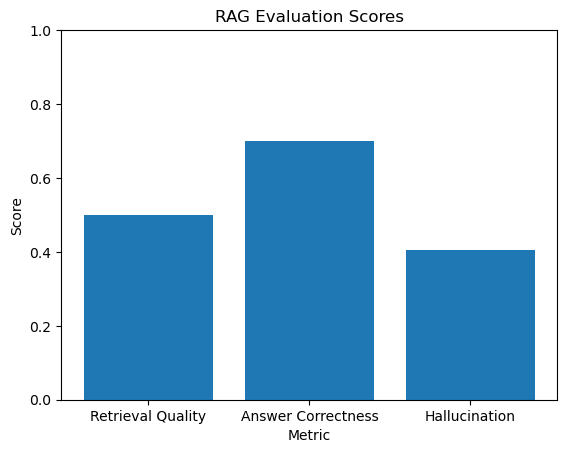

In [20]:
def plot_scores(scores):
    """
    Plot the evaluation scores.
    """
    labels = ["Retrieval Quality", "Answer Correctness", "Hallucination"]
    scores = [scores["retrieval_quality"], scores["answer_correctness"], scores["hallucination"]]
    
    _, ax = plt.subplots()
    ax.bar(labels, scores)
    ax.set_xlabel('Metric')
    # set y range to 0-1
    ax.set_ylim(0, 1)
    ax.set_ylabel('Score')
    ax.set_title('RAG Evaluation Scores')
    plt.show()

plot_scores(results["scores"])

#### Reflections 

The RAG setup worked pretty well. The system was able to find the right pieces of information most of the time, and the answers it generated were accurate and matched what we expected. 

20% of the answers added extra info that wasn’t actually in the source document suggesting that the model hallucinated a bit. That is however a general problem for LLMs so we took the model from the exercise as a benchmark and our model performed good enough to be happy with the results. 

Regarding the hyperparameters:
- We chose Fixed-sized chunking for its simplicity and relevance to the context, since the data we analyzed was a political speech.
- Semantic chunking could improve the results, but since our model was generalizing well enough, we decided not to over-complicate things.
- The chunk size had to be reduced from 1000 to 500, because the WatsonX embedding model has a token limit of 512 tokens.
- More generally, parameters like retriever, top-k size, or prompt structure could improve our model, but in this context, it would rather complicate things, which was not necessary.
- Using a simple prompt format worked fine, but more controlled prompting might reduce hallucination even more.